![](../img/330-banner.png)

# Tutorial 2

UBC 2025-26

## Outline

During this tutorial, we will focus on the ideas of generalization, training, validation and test scores, and cross-validation. Additionally, we will play with different algorithms and see how their hyperparameters affect their complexity.

All questions can be discussed with your classmates and the TAs - this is not a graded exercise!

## Imports

In [1]:
# import the libraries
import os
import sys
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
# from plotting_functions import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

DATA_DIR = os.path.join(os.path.abspath(".."), "data/")
pd.set_option("display.max_colwidth", 200)

We are going to practice ML fundamentals on a dataset about building characteristics and energy consumption. You may download the dataset [here](https://www.kaggle.com/datasets/govindaramsriram/energy-consumption-dataset-linear-regression?select=train_energy_data.csv) (make sure to download the file called `training_energy_data.csv`. At this page, you will also find information about the different features.

In [2]:
energy_df = pd.read_csv(DATA_DIR + 'train_energy_data.csv')
energy_df

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17
...,...,...,...,...,...,...,...
995,Residential,14419,68,44,23.95,Weekend,3661.21
996,Industrial,12194,7,22,14.67,Weekend,3546.34
997,Commercial,39562,88,20,32.18,Weekday,5147.21
998,Residential,8348,67,37,16.48,Weekend,3244.98


We are going to try to predict the energy consumption of a building given its characteristics - this is a **regression** problem.

## EDA: Exploratory Data Analysis

### <font color='red'>Question 1</font>

Let's start answering some questions about this dataset:

- How many samples are included in the dataset?
- Are the columns the correct type (strings as strings, numbers as numbers)? Do we have missing data?
- Looking at the column names (and [descriptions](https://www.kaggle.com/datasets/abrambeyer/openintro-possum/data)), do you think some of them would be more or less helpful in predicting the building energy consumption?
- What is the square footage of the largest building in the dataset?

In [3]:
# How many data points do we have? 
energy_df.shape[0]

1000

In [4]:
# What is the type and count for each column?
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


In [5]:
# What are the columns in the dataset? 
energy_df.columns

Index(['Building Type', 'Square Footage', 'Number of Occupants',
       'Appliances Used', 'Average Temperature', 'Day of Week',
       'Energy Consumption'],
      dtype='object')

In [6]:
# describe gives a summary of the numerical features in the dataframe
energy_df.describe()

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Energy Consumption
count,1000.000,1000.000000,1000.000000,1000.000000,1000.000000
mean,25462.388,48.372000,25.606000,22.611390,4166.252570
std,14294.554,29.061972,14.105166,7.139943,933.313064
min,560.000,1.000000,1.000000,10.050000,1683.950000
25%,13169.750,22.000000,13.000000,16.475000,3509.482500
50%,25477.000,47.000000,26.000000,22.815000,4175.730000
75%,37446.250,73.250000,38.000000,28.850000,4863.850000
max,49997.000,99.000000,49.000000,34.990000,6530.600000


EDA can be much more extensive, but for this exercise we will stop here. 

Before we proceed, we will need to drop the `Building Type` and `Day of Week` features as these are categorical and we have not talked yet about handling features of different type. 

We will keep all the other (numerical) features and separate them from the target.

In [7]:
# Dropping unused features, and separating features and target

X = energy_df.drop(columns = ['Building Type', 'Day of Week', 'Energy Consumption'])
y = energy_df['Energy Consumption']

## Data splitting

As discussed in class, it is important for models to generalize to unseen data, therefore we will set aside a subset of samples to evaluate the model on samples it has not been trained on.

This is a rather small dataset, so we will have to compromise to have enough data for training and testing. Saving 20% for testing sounds acceptable.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## <font color='red'>Question 3: Baseline model</font>

As always, we will start by building a baseline model to use as reference. Build and score your model in the cell below. Remember that this is a *regression* problem, so you will not use `DummyClassifier`, but the corresponding model for regression!

Also, remember to score the model on the training and test set.

In [9]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor()

dummy_regr.fit(X, y)

dummy_regr.score(X, y)

0.0

**Note:** did you check the value of a prediction from the baseline model? It is very close to the mean of `Energy Consumption`, as expected! But not exactly the same, as we set some samples aside for testing.

## <font color='red'>Question 4: Decision tree</font>

Let's now try a more sofisticated approach. We will use a `DecisionTreeRegressor` to predict the energy consumption of a building. Run the code below and answer the following questions:
- Why is there a large gap between train and test scores?
- What would be the effect of increasing or decreasing test_size? How would that affect your confidence in the test score?

In [10]:
# Instantiate a class object 
dt = DecisionTreeRegressor(random_state=123)

# Train a decision tree on X_train, y_train
dt.fit(X_train, y_train)

# Score on the train set
dt.score(X_train, y_train)

1.0

In [11]:
# Score on the test set
dt.score(X_test, y_test)

0.5488206169941388

In [12]:
# If you are curious, you can see the depth of this tree - what do you think of this value? What does it tell us?
dt.get_depth()

16

## <font color='red'>Question 5: Hyperparameter tuning</font>

The model above is showing clear signs of **overfitting:** it learned *too much* from the training set, including noise and errors, and that has a negative impact on its ability to predict unseen samples. To fix his, we are going to force the tree to *learn less* by reducing its maximum depth.

As we search for the best depth for our tree, we need to further split the training set in training and validation, to avoid using the test set for hyperparameter tuning (which means breaking the golden rule - the test set can not influence the model in any way, not even in the choice of hyperparameter).

Let's move 20% of samples from the training set to the validation set.

In [15]:
# Create a validation set 
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

Now, we will try different depth values and choose the best one.

In [16]:
tr_scores = []
valid_scores = []
depths = np.arange(1, 35, 2)

for depth in depths:  
    # Create and fit a decision tree model for the given depth  
    dt = DecisionTreeRegressor(max_depth=depth, random_state=123)

    dt.fit(X_tr, y_tr)
    # Calculate and append r2 scores on the training and validation sets
    tr_scores.append(dt.score(X_tr, y_tr))    
    valid_scores.append(dt.score(X_valid, y_valid))
    
results_single_valid_df = pd.DataFrame({"train_score": tr_scores, 
                           "valid_score": valid_scores},index = depths)
results_single_valid_df.head()

,train_score,valid_score
1,0.468672,0.424703
3,0.690115,0.625682
5,0.836817,0.680838
7,0.912847,0.624382
9,0.968857,0.562680


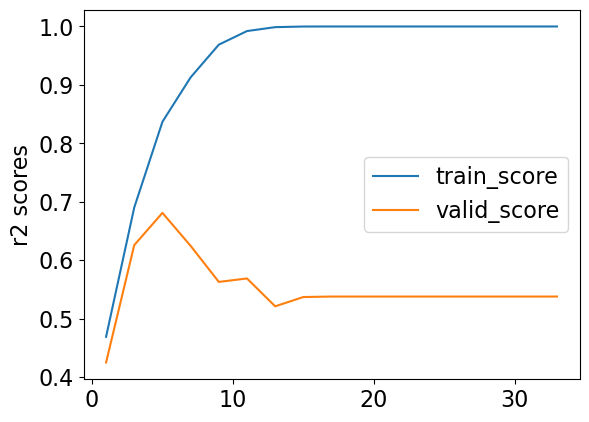

In [17]:
# Plotting the results above
results_single_valid_df[['train_score', 'valid_score']].plot(ylabel='r2 scores');

Answer the following questions:
- What is the best tree depth? How did you choose this value?
- How would you describe gap between training and validation set for smaller depth values? And what about higher values?

## <font color='red'>Question 5: Cross-validation</font>

Our validation set is quite small - only 160 samples. This means that it could allow for some significant variance in the score if a different set was picked.

In [19]:
# To check the size of the validation set
X_valid.shape[0]

160

In the cell below, we are going to observe this phenomenon, by using `cross_validate` on our best tree candidate (`max_depth` = 5). See how the test_scores change with every different fold?

**Notes:** 
- `cross_validate` has no concept of validation set, and it calls it test set instead. For our purposes, test_scores are validation scores
- Because we are using cross-validation, we can use the original X_train set, before we further divided it in training and validation set

In [22]:
dt_best = DecisionTreeRegressor(max_depth=5, random_state=123)

scores = cross_validate(dt_best, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.048532,0.002902,0.724011,0.817920
1,0.001871,0.000556,0.743820,0.817159
2,0.001709,0.000515,0.680437,0.829887
3,0.001714,0.000510,0.683061,0.820287
4,0.001609,0.000474,0.585609,0.824735
5,0.001601,0.000470,0.731733,0.804337
6,0.001598,0.000539,0.772245,0.811297
7,0.001475,0.000433,0.696508,0.818936
8,0.001468,0.000402,0.709784,0.815890
9,0.001370,0.000400,0.713195,0.825460


In [23]:
# Average of above values
pd.DataFrame(pd.DataFrame(scores).mean())

,0
fit_time,0.006295
score_time,0.000720
test_score,0.704040
train_score,0.818591


Answer the following questions:
- What is the highest validation score? And lowest? How far are they from the mean value? Would it have been possible for us to see any of these scores if we used only one validation set?
- How did cross-validation help us getting a more robust score measure?
- Fold 6 has the best validation score. Shouldn't we just use the model fitted on this particular training fold?

#### Final note

Cross-validation is often used in the context of hyperparameter tuning, such as in the code below

In [24]:
depths = np.arange(1, 35, 2)

cv_train_scores = []
cv_valid_scores = []
for depth in depths: 
    # Create and fit a decision tree model for the given depth   
    dt = DecisionTreeRegressor(max_depth = depth, random_state=123)

    # Carry out cross-validation
    results = cross_validate(dt, X_train, y_train, cv=5, return_train_score=True)
    cv_train_scores.append(results['train_score'].mean())
    cv_valid_scores.append(results['test_score'].mean())    

In [25]:
results_df = pd.DataFrame({"train_score": cv_train_scores, 
                           "valid_score": cv_valid_scores
                           },
                           index=depths
                            )
results_df

,train_score,valid_score
1,0.469953,0.441036
3,0.689356,0.638822
5,0.818982,0.696107
7,0.906510,0.653371
9,0.963641,0.598821
11,0.991052,0.576565
13,0.998569,0.568474
15,0.999885,0.573941
17,0.999999,0.575190
19,1.000000,0.573275


Thanks to cross-validation, the validation scores that you see in this example are more stable than the scores one could obtain using a single validation set (and again, 5 seems to be the best depth for this problem).

**The purpose of cross-validation, however, is not hyperparameter tuning.** Cross-validation does not give us the best hyperparameters for the model. It produces a more robust score for a specific model and a specific set of hyperparameters, set by us.

**Because they are often seen together, people can mistake cross-validation and hyperparameter tuning as being the same thing.** But because you did this tutorial, you will not get confused anymore 😊.

In [27]:
# Last step: final training and scoring on test set. Pick the correct sets for this task!

model = DecisionTreeRegressor(max_depth=5)

model.fit(X_train, y_train)

model.score(X_test, y_test)

0.7097425133911417

## <font color='red'>Question 6: Hyperparameters playground</font>

We are now going to look at a different problem - a classification one - to see the impact on different hyperparameters on model learning.

In this interactive playground, you will investigate how various algorithms create decision boundaries to distinguish between Iris flower species using their sepal length and width as features. By adjusting the parameters, you can observe how the decision boundaries change, which can result in either overfitting (where the model fits the training data too closely) or underfitting (where the model is too simplistic).

- With **k-Nearest Neighbours ($k$-NN)**, you'll determine how many neighboring flowers to consult. Should we rely on a single nearest neighbor? Or should we consider a wider group? 

- With **Support Vector Machine (SVM)** using the RBF kernel, you'll tweak the hyperparameters `C` and `gamma` to explore the tightrope walk between overly complex boundaries (that might overfit) and overly broad ones (that might underfit).
  
- With **Decision trees**, you'll observe the effect of `max_depth` on the decision boundary. 

Observe the process of crafting and refining decision boundaries, one parameter at a time! Be sure to take breaks to reflect on the results you are observing, and answer the following questions:

- For each hyperparameter, write down the relationship between value and model complexity (does the complexity increase with the value or vice-versa?).
- What hyperparameter value (or combination of values) seems to give the best results for each model? Is this problem better solved by complex models, or simpler ones? **Hint:** the dataset is small, which increases the risk of overfitting if we pick too complex models.
- Describe the appearance of the decision boundaries for each model. Which model presents as smooth, curved lines? Which one looks like a very fragmented line? Note that the appearance will vary as you change the hyperparameter values, but you should be able to spot some common patterns...

Column
    [0] Row
        [0] FloatSlider(end=5, name='C (log scale)', start=1, value=1.0)
        [1] IntSlider(end=40, name='n_neighbors', start=1, value=5)
    [1] Row
        [0] FloatSlider(end=5, name='Gamma (log scale)', start=-3, value=1.0)
        [1] IntSlider(end=20, name='max_depth', start=1, value=3)
    [2] ParamFunction(function, _pane=Matplotlib, defer_load=False)
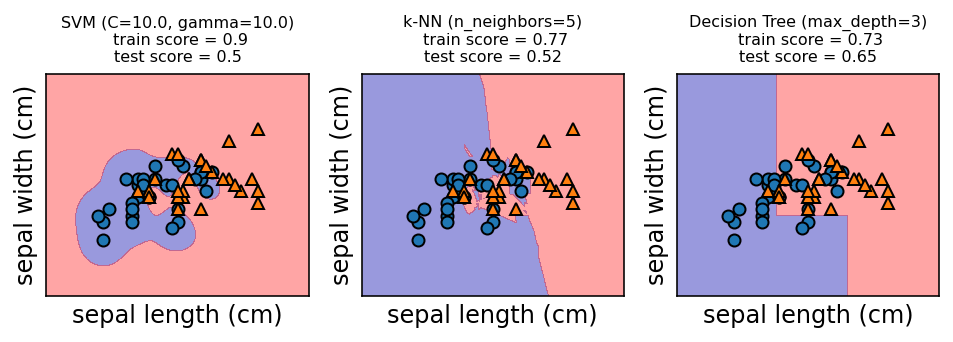

In [29]:
from matplotlib.figure import Figure

import panel as pn
from panel import widgets
from panel.interact import interact

pn.extension()

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from ipywidgets import interact, FloatLogSlider, IntSlider
import mglearn


# Load dataset and preprocessing
iris = load_iris(as_frame=True)
iris_df = iris.data
iris_df['species'] = iris.target
iris_df = iris_df[iris_df['species'] > 0]
X, y = iris_df[['sepal length (cm)', 'sepal width (cm)']], iris_df['species']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)


# Common plot settings
def plot_results(model, X_train, y_train, title, ax):
    mglearn.plots.plot_2d_separator(model, X_train.values, fill=True, alpha=0.4, ax=ax);
    mglearn.discrete_scatter(
        X_train["sepal length (cm)"], X_train["sepal width (cm)"], y_train, s=6, ax=ax
    );
    ax.set_xlabel("sepal length (cm)", fontsize=12);
    ax.set_ylabel("sepal width (cm)", fontsize=12);
    train_score = np.round(model.score(X_train.values, y_train), 2)
    test_score = np.round(model.score(X_test.values, y_test), 2)
    ax.set_title(
        f"{title}\n train score = {train_score}\ntest score = {test_score}", fontsize=8
    );
    pass


# Widgets for SVM, k-NN, and Decision Tree
c_widget = pn.widgets.FloatSlider(
    value=1.0, start=1, end=5, step=0.1, name="C (log scale)"
)
gamma_widget = pn.widgets.FloatSlider(
    value=1.0, start=-3, end=5, step=0.1, name="Gamma (log scale)"
)
n_neighbors_widget = pn.widgets.IntSlider(
    start=1, end=40, step=1, value=5, name="n_neighbors"
)
max_depth_widget = pn.widgets.IntSlider(
    start=1, end=20, step=1, value=3, name="max_depth"
)


# The update function to create the plots
def update_plots(c, gamma=1.0, n_neighbors=5, max_depth=3):
    c_log = round(10**c, 2)  # Transform C to logarithmic scale
    gamma_log = round(10**gamma, 2)   # Transform Gamma to logarithmic scale

    fig = Figure(figsize=(8, 2))
    axes = fig.subplots(1, 3)

    models = [
        SVC(C=c_log, gamma=gamma_log, random_state=42),
        KNeighborsClassifier(n_neighbors=n_neighbors),
        DecisionTreeClassifier(max_depth=max_depth, random_state=42),
    ]
    titles = [
        f"SVM (C={c_log}, gamma={gamma_log})",
        f"k-NN (n_neighbors={n_neighbors})",
        f"Decision Tree (max_depth={max_depth})",
    ]
    for model, title, ax in zip(models, titles, axes):
        model.fit(X_train.values, y_train)
        plot_results(model, X_train, y_train, title, ax);
    # print(c, gamma, n_neighbors, max_depth)
    return pn.pane.Matplotlib(fig, tight=True);


# Bind the function to the panel widgets
interactive_plot = pn.bind(
    update_plots,
    c=c_widget.param.value_throttled,
    gamma=gamma_widget.param.value_throttled,
    n_neighbors=n_neighbors_widget.param.value_throttled,
    max_depth=max_depth_widget.param.value_throttled,
)

# Layout the widgets and the plot
dashboard = pn.Column(
    pn.Row(c_widget, n_neighbors_widget),
    pn.Row(gamma_widget, max_depth_widget),
    interactive_plot,
)

# Display the interactive dashboard
dashboard